<a href="https://colab.research.google.com/github/RusAl84/IntroML/blob/master/14_%D0%90%D0%BD%D1%81%D0%B0%D0%BC%D0%B1%D0%BB%D0%B8_%D0%91%D1%83%D1%81%D1%82%D0%B8%D0%BD%D0%B3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ансамбли. Бустинг

Другой вид ансамблей это бустинг (от англ. boosting - улучшение), когда модели строятся последовательно, каждая следующая пытается скомпенсировать ошибки предыдущей, а общий результат - какая-то смесь результатов моделей из ансамбля. Много видов бустинга предложено, мы познакомимся только с некоторыми из них.

## Adaboost

Один из популярных видов бустинга это метод Adaboost  (сокращение от Adaptive Boosting) и различные его модификации.
Идея Adaboost довольно проста:
* давайте будем обучать модели используя функцию ошибки, в которой каждому обучающему примеру назначен некоторый вес, который регулирует насколько важна ошибка на этом примере. Назначим маленький вес - ошибка на примере почти не будет влиять на общую ошибку, а назначим большой вес - ошибка на таком примере сразу даст большую общую ошибку.

$ E=\sum_i w_i*e_i , \sum_i w_i = 1, w_i \geq 0 $

* Обучим первую модель, изначально все веса для обучающих примеров выберем одинаковыми (равными единица поделить на число примеров). Эта модель на каких-то примерах будет иметь большую ошибку, на каких-то маленькую. $ w_i^{(0)}=1/N $
* Пересчитаем веса примеров так, чтобы сделать их побольше для примеров на которых большая ошибка, и поменьше для примеров, на которых ошибка первой модели маленькая (чтобы не было вычислительных проблем будем всегда считать так, чтобы сумма всех весов была равна 1).
* Обучим вторую модель на тех же самых примерах, но теперь у этих примеров будут другие веса с предыдущего шага, и как результат, ошибка тоже будет другая. И для этой модели посмотрим на каких примерах ошибка маленькая, на каких большая, и изменим веса аналогично предыдущему пункту - увеличим их для примеров с большой ошибкой и уменьшим для примеров с маленькой ошибкой.
* Будем продолжать обучать все новые и новые модели на тех же примерах, но с другими весами, пока нам не надоест или не достигнем какого-то условия остановки обучения.
* В конечном итоге у нас будет много обученных моделей и общий результат возьмем как некоторое взвешенное среднее от результатов каждой модели (конкретные коэффициенты в таком среднем зависят от ошибки каждой модели).

<details> 
 <summary> <i>Дополнительно:</i> (нажмите)</summary>

    Если вам интересны конкретные формулы такого расчета, то можете посмотреть их в работах:
    - для классификации:  J. Zhu, H. Zou, S. Rosset, T. Hastie. “Multi-class AdaBoost”, 2009.
    - для регрессии: Drucker. “Improving Regressors using Boosting Techniques”, 1997.
    
</details>
 

В библиотеке `sklearn` в модуле `ensemble` метод Adaboost реализован в функциях [`AdaBoostClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) для задач классификации и [`AdaBoostRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor) для задач регрессии. 

Можем задать аргументы:  
- `base_estimator` — базовый алгоритм модели в ансамбле. По умолчанию используется DecisionTreeClassifier(max_depth=1).
- `n_estimators` — максимальное количество моделей в ансамбле, после которого бустинг прекращается. Если ансамбль полностью обучится раньше, то моделей будет меньше.
- `learning_rate` — ограничивает вклад каждой модели в изменение весовых коэффициентов, по умолчанию равно 1. Снижение этого параметра будет означать, что весовые коэффициенты будут изменяться в меньшей степени, вынуждая модель дольше обучаться (но иногда повышается качество обучения).
- и другие.

Объекты Adaboost имеют атрибуты:
* `base_estimator_` - тип моделей в ансамбле.
* `estimators_` - список обученных моделей ансамбля.
* `estimator_weights_`-  вклад (вес) каждой модели в результат ансамбля
* `estimator_errors_` - ошибка каждой модели в ансамбле 
* `feature_importances_` - важность признаков (если есть у базовой модели)

у классификатора есть еще
* `classes_` - метки классов
* `n_classes_` - число классов

Реализованы методы, аналогичные другим моделям `fit()`,`predict()` и прочие, но есть и специфичные:
* `staged_decision_function(self, X)` - для классификатора вычисляет уровни принадлежности к классу для каждой модели ансамбля по мере их создания, удобно для наблюдения за процессом обучения  
* `staged_predict(self, X)` - вычисляет выходы для каждой модели ансамбля
* `staged_score(self, X, y[, sample_weight])` - вычисляет ошибки для каждой модели ансамбля.
* и другие	

Давайте реализуем это метод Adaboost для классификации.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier # подключим модуль Adaboost
from sklearn import datasets # наборы данных
from sklearn.model_selection import train_test_split # разделение на обучение и тест
from sklearn import metrics # метрики

iris = datasets.load_iris() # загрузим набор данных ирисов

X = iris.data # входы (признаки)
y = iris.target # указания учителя

# разделим данные на обучающие и тестовые
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# создадим Adaboost классификатор, по умолчанию - на основе деревьев
abc = AdaBoostClassifier(n_estimators=50, learning_rate=1)
# обучим его
model = abc.fit(X_train, y_train)
# проверим на тесте
y_pred = model.predict(X_test)
# посчитаем метрики
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))



Accuracy: 0.9777777777777777


In [ ]:
abc.feature_importances_

array([0.  , 0.  , 0.66, 0.34])

Аналогично с другими базовыми моделями. Например на основе машины опорных векторов SVC:

In [ ]:
from sklearn.svm import SVC
# создаем базовый классификатор
svc=SVC(probability=True, kernel='linear')
# создаем Adaboost классификатор из них
abc = AdaBoostClassifier(base_estimator=svc, n_estimators=50, learning_rate=1)

# обучаем
model = abc.fit(X_train, y_train)
# тестируем
y_pred = model.predict(X_test)
# считаем метрики
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.


Accuracy: 0.9333333333333333


Посмотрим как изменяется ошибка каждой следующей модели в ансамбле в обучении при разных величинах шага `learning_rate`, изменяйте его.

`base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.


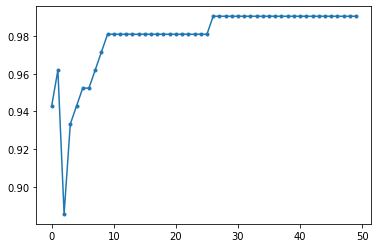

In [ ]:
# посмотрим как изменялась ошибка при обучении
from matplotlib import pyplot as plt
learning_rate=0.1
abc = AdaBoostClassifier(base_estimator=svc, n_estimators=50, learning_rate=learning_rate)
model = abc.fit(X_train, y_train)
score=[ s for s in abc.staged_score(X_train, y_train)]
plt.plot(score,marker='.')
#plt.yscale('log')

Посмотрим на разделяющие поверхности:

In [ ]:

# функция  для рисования разделяющей поверхности на плоскости

# Div_plate(clf,flip_level) принимает объект-классификатор и уровень шума (ошибок)
# создает двумерные данные, обучает классификатор, рисует разделяющую поверхность 

def Div_plate(clf, flip_level):
    from sklearn.datasets import make_classification # для генерации данных
    from sklearn.model_selection import train_test_split # для разделения на обучение и тест
    import numpy as np
    import seaborn as sns # для простого отображения
    import matplotlib.pyplot as plt #
    # создаем данные
    X,y = make_classification(n_samples=10000, # число примеров
                              n_features=2, # число признаков (атрибутов)
                              n_informative=2, # из них информативных
                              n_redundant=0, # из них не информативных
                              n_repeated=0, # из них повторяющихся
                              n_classes=2, # число классов
                              n_clusters_per_class=1, # число кластеров на класс
                              class_sep=2, # влияет на расстояние между кластерами
                              flip_y=flip_level, # доля ошибок (шума)
                              weights=[0.5,0.5], # пропорции числа данных в классах
                              random_state=17) # 

    # разделяем на обучающие и тестовые, случайно
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)
    # рисуем данные
    plt.subplots();#
    ax1=plt.gca();#
    sns.scatterplot(X_train[:,0],X_train[:,1],hue=y_train,ax=ax1);# обучающие
    sns.scatterplot(X_test[:,0],X_test[:,1],hue=y_test,ax=ax1,marker="+");# тестовые
    ax1.set_title("Data With Noise");#
    plt.show();#
    # Создаем классификатор на основе случайного леса. Изменяйте параметры и смотрите как это влияет на обучение
    clf.fit(X_train, y_train) # обучаем 
    y_pred = clf.predict(X_test) # проверяем на тесттовых данных
    score=clf.score(X_test, y_test) # считаем среднюю точность
    print('Score=',score)
    ind=y_test==y_pred; # индексы совпадений результата классификации и меток классов
    plt.subplots(); 
    ax2=plt.gca();
    # рисуем "правильно" распознанные примеры
    sns.scatterplot(X_test[ind,0],X_test[ind,1],hue=y_test[ind],ax=ax2);
    # рисуем "неправильно" распознанные примеры
    sns.scatterplot(X_test[~ind,0],X_test[~ind,1],hue=y_pred[~ind],ax=ax2,marker="+");
    #sns.scatterplot(X_test[:,0],X_test[:,1],hue=y_test[:],ax=ax2,marker="+");
    ax2.set_title("With Noise");
    # считаем и рисуем разделяющую поверхность.
    plot_step=0.01
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1 # немного измененные минимальное и максимальые значения превого атрибута 
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1 # немного измененные минимальное и максимальые значения второго атрибута 
    # считаем прямоугольную сетку возможных значений этих атрибутов
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step), #
                         np.arange(y_min, y_max, plot_step)) #
    # считаем выход классификатора для всех примеров сетки
    # не забыв что массивы данных нужно привести к требуемому размеру.
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]) 
    Z = Z.reshape(xx.shape) # и преобразуем обратно в исходному размеру
    # рисуем разделяющую поверхность
    cs = plt.contourf(xx, yy, Z, levels=1, colors=['blue','orange'],alpha=0.3) # рисуем контурную карту
    plt.show();

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


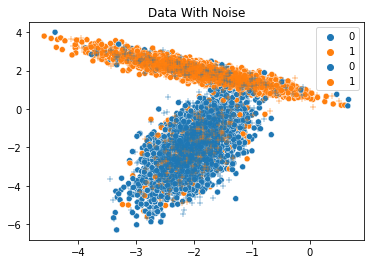

Score= 0.8896969696969697


Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


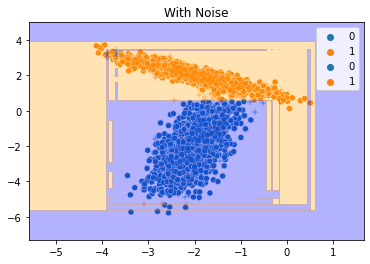

In [ ]:

from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
# создаем Adaboost классификатор из них
#clf=LogisticRegression()
abc = AdaBoostClassifier(# base_estimator=clf,
                         n_estimators=100, 
                         learning_rate=1) # дерево по умолчанию

flip_level=0.2 # уровень шума
Div_plate(abc,flip_level) # рисуем разделяющие поверхности



# Градиентный бустинг. Xgboost
Другая идея бустинга заключается в следующем:
* Пусть мы имеем входы **X** и указания учителя **Y**.
* Обучим первую модель на этих данных, если модель простая,  то обучение будет не очень точным и выход модели будет **F1**, а должны были получить **Y**.
* Обучим вторую модель на тех же данных, но для нее указания учителя сделаем **Y-F1**, получим выход **F2**, который тоже может отличаться от желаемого. 
* тогда обучим третью модель, для которой указания учителя будут **Y-F2**, получим выход **F3**.
* будем продолжать обучать все новые и новые модели, пока не надоест или пока не достигнем хорошего обучения или других критериев останова. 
* Результат ансамбля, выход F=F1+F2+F3+...

Если внимательно присмотреться, то величина **(Y - F1)** это градиент по **F1** (со знаком минус) от средневквадратичной ошибки \\(0.5*(Y-F1)^2\\), потому такой бустинг называют ["градиентный бустинг"](https://en.wikipedia.org/wiki/Gradient_boosting), а величины **(Y - F1)** - "остатками" (residuals). 

Для более общего случая, когда функция ошибки не среднеквадратичная, процесс аналогичен:
* Для начальной модели выберем, например, начальную функцию константой, F_0=С, константу можно подобрать оптимальной для функции ошибки.
* в цикле по количеству моделей в ансамбле 
    * посчитаем остаток как минус градиент функции ошибки по выходам F текущего ансамбля
    * создадим и обучим новую модель компенсировать этот остаток (т.е. остаток это указание учителя в обучении), ее выход F_i.
    * Посчитаем новый выход ансамбля как **F_new=F_old+(вес_i) * F_i**  добавив выход новой модели с  некоторым весом, оптимальное значение которого можно найти. 
* в конечном итоге получим выход всего обученного ансамбля.


Для улучшения метода можно обучать новые модели не на том же наборе данных а на *бутстрапе* его, как делали для случайного леса.

Множество реализаций градиентного бустинга существуют. В `sklearn` есть [`GradientBoostingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)  и 
[`GradientBoostingRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor) для градиентного бустинга деревьев, но наверное одна из наиболее известных это реализация [**xgboost**](https://xgboost.readthedocs.io/en/latest/parameter.html) сделанная в одноименной библиотеке. Хоть это другая библиотека, синтаксис очень похож, в [`XGBClassifier`](https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=xgbclassifier#xgboost.XGBClassifier) и [`XGBRegressor`](https://xgboost.readthedocs.io/en/latest/python/python_api.html?highlight=xgbregressor#xgboost.XGBRegressor) реализован бустинг деревьев и линейных моделей. Посмотрим пример.






Эти команды обладают довольно большим списком аргументов, в том числе можно задать гиперпараметры для регулризации. О регуляризации см. [здесь](https://albertum.medium.com/l1-l2-regularization-in-xgboost-regression-7b2db08a59e0).

In [ ]:
import numpy #
import xgboost # подключим библиотеку XGboost
from sklearn.metrics import accuracy_score #
from sklearn.model_selection import train_test_split #
# загрузим данные для классификации
URL='https://drive.google.com/uc?id=1soReu6FBB_4LxvuNnV_ULUW-WGlNaZg2'
dataset = numpy.loadtxt(URL, delimiter=",")

# в них последний столбец это класс, остальные - признаки
X = dataset[:,0:8] # помним, что в срезе последний элемент не входит в диапазон 
Y = dataset[:,8] #
# разделяем данные на обучающие и тестовые
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

# обучаем градиентный бустинг деревьев (по умолчанию)
model = xgboost.XGBClassifier() # создаем объект
model.fit(X_train, y_train) # обучаем его

# вычисляем выход на тесте
predictions = model.predict(X_test) #

# считаем точность
accuracy = accuracy_score(y_test, predictions) #
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 74.02%


## Catboost
Стоит упомянуть другую популярную библиотеку [**Catboost**](https://catboost.ai/) (сокр. от categorical boosting, к котикам отношения не имеет) для градиентного бустинга деревьев. Синтаксис в целом похож, но дает настраивать большее число параметров. Особо отличается тем, что позволяет работать с категориальными признаками сразу, без предобработки, библиотека сама сделает все необходимые предобработки. Сейчас посмотрим только примеры, для более глубокого погружения в возможности библиотеки изучайте документацию и примеры самостоятельно. 

Библиотеку надо установить.

In [ ]:
# установка библиотеки
!pip install catboost 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Обучающие данные заносятся в "пул" (Pool), объект, который будет содержать и выдавать их по мере необходимости, надо указвать индексы категориальных переменных. Классификатор [CatBoostClassifier](https://catboost.ai/docs/concepts/python-reference_catboostclassifier.html) имеет множество аргументов, из них нам особенно важны:
* iterations - число моделей в ансамбле,
* learning_rate - шаг обучения
* depth - максимальная глубина дерева 

In [ ]:
from catboost import Pool, CatBoostClassifier # подключаем инструмент для оперирования с данными Pool и классификатор
# данные для обучения - одна категориальная и две вещественные переменные
train_data = [["summer", 1924, 44],
              ["summer", 1932, 37],
              ["winter", 1980, 37],
              ["summer", 2012, 204]]
# данные для теста
eval_data = [["winter", 1996, 197],
             ["winter", 1968, 37],
             ["summer", 2002, 77],
             ["summer", 1948, 59]]

cat_features = [0] # номера категориальных переменных

train_label = ["France", "USA", "USA", "UK"] # указания учителя для обучения
eval_label = ["USA", "France", "USA", "UK"] # укзания учителя для теста

# создаем обучающий набор данных 
train_dataset = Pool(data=train_data, # сами данные
                     label=train_label, # указания учителя
                     cat_features=cat_features) # индексы категориальных переменных
# аналогично для тестовых данных
eval_dataset = Pool(data=eval_data, #
                    label=eval_label, #
                    cat_features=cat_features) #

# создаем модель CatBoostClassifier
model = CatBoostClassifier(iterations=10, # число моделей в ансамбле
                           learning_rate=1, # шаг обучения
                           depth=2, # глубина дерева
                           loss_function='MultiClass') # вид функции ошибки
# обучаем ансамбль
model.fit(train_dataset)
# считаем выходы после обучения на тестовых данных
preds_class = model.predict(eval_dataset)
# считаем вероятности классов
preds_proba = model.predict_proba(eval_dataset)
preds_class

0:	learn: 0.9417331	total: 1.93ms	remaining: 17.3ms
1:	learn: 0.8421839	total: 2.18ms	remaining: 8.74ms
2:	learn: 0.6597822	total: 2.31ms	remaining: 5.39ms
3:	learn: 0.6028493	total: 2.44ms	remaining: 3.66ms
4:	learn: 0.4900112	total: 2.55ms	remaining: 2.55ms
5:	learn: 0.4076408	total: 2.66ms	remaining: 1.77ms
6:	learn: 0.3458205	total: 2.78ms	remaining: 1.19ms
7:	learn: 0.2982687	total: 2.88ms	remaining: 719us
8:	learn: 0.2608927	total: 2.99ms	remaining: 332us
9:	learn: 0.2309514	total: 3.09ms	remaining: 0us


array([['USA'],
       ['USA'],
       ['UK'],
       ['USA']], dtype=object)

# Кроссвалидация
Можно использовать `cv` - скользящий контроль ("кроссвалидация", англ. cross validation), когда обучается множество моделей, обучающие данные разбиваются на N частей (случайно), каждая модель обучается на N-1 своих частях данных, а одна часть данных используется для тестирования этой модели, см. рис. (зеленое - обучающие данные, синее - тестовые)

![img](https://drive.google.com/uc?id=1vKqQNMZ_Xjj-nABJI5I3m-Lm0ctzHjs_)

Библиотека поддерживает интерактивную визуализацию процесса обучения ([Настройки отображения](https://catboost.ai/docs/installation/python-installation-additional-data-visualization-packages.html#python-installation-additional-data-visualization-packages) ) для чего указываем аргумент `plot="True"`

Но в Colab визуализация не работает, разработчики библиотеки ничего не могут сделать. Так что мы не увидим красивых картинок. На своем компьютере вы можете такие картинки увидеть.

In [ ]:
from catboost import Pool, cv # подключам модуль
# данные для обучения и кроссвалидации
cv_data = [["France", 1924, 44],
           ["USA", 1932, 37],
           ["Switzerland", 1928, 25],
           ["Norway", 1952, 30],
           ["Japan", 1972, 35],
           ["Mexico", 1968, 112]]
# указания учителя
labels = [1, 1, 0, 0, 0, 1]

cat_features = [0] # категориальные переменные
# создаем обучающий набор 
cv_dataset = Pool(data=cv_data, # данные
                  label=labels, # указания учителя
                  cat_features=cat_features) # категориальные переменные
# параметры обучения
params = {"iterations": 100, # максимальное число моделей в ансамбле
          "depth": 2, # глубина дерева
          "loss_function": "Logloss", # вид функции ошибки
          "verbose": False} # отображение процесса текстом
# обучение и кроссвалидация
scores = cv(cv_dataset, # данные на которых обучаем
            params, # параметры обучения
            fold_count=3,  # число разбиений данных для кроссвалидации 
            plot="False") # отображение интерактивных графиков


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/3]

bestTest = 0.6806661468
bestIteration = 1

Training on fold [1/3]

bestTest = 0.7062352628
bestIteration = 0

Training on fold [2/3]

bestTest = 0.693188484
bestIteration = 0



In [ ]:
scores # посмотрим на результаты тестирования, среднее и разброс (std) для ошибки обучения и теста.

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.701886,0.007533,0.686716,7.850462e-17
1,1,0.693624,0.012898,0.661645,1.110223e-16
2,2,0.702647,0.006738,0.637718,0.000000e+00
3,3,0.716449,0.014089,0.625042,8.796724e-03
4,4,0.710532,0.006287,0.606618,8.448647e-03
...,...,...,...,...,...
95,95,1.102985,0.195439,0.099079,7.536046e-03
96,96,1.109511,0.194170,0.097707,7.360085e-03
97,97,1.115997,0.192900,0.096368,7.189676e-03
98,98,1.122444,0.191630,0.095060,7.024605e-03


Посмотрим на пример регрессии, [оценки стоимости недвижимости](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html#sklearn.datasets.fetch_california_housing). Используем данные california из sklearn. Загрузите эти данные и посмотрите на признаки, сколько их, какой тип?

In [ ]:
import numpy as np
from catboost import CatBoostRegressor, Pool # регрессор

import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
# from sklearn.datasets import load_boston # уже исключен из наборов
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance # для оценки важности признаков

from sklearn.datasets import fetch_california_housing

housing=fetch_california_housing()
X,y = housing.data, housing.target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=5) # разделим на обучение и тест

 

In [ ]:
train_dataset = Pool(X_train, y_train) # создаем пул обучающих данных
test_dataset = Pool(X_test, y_test) # создаем пул тестовых данных

In [ ]:
model = CatBoostRegressor(loss_function='RMSE') # создаем модель для регрессии

Библиотека позволяет проводить подбор гиперпараметров, как в sklearn.

In [ ]:
# задаем "сетку" параметров, варианты, которые нужно проверить
grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
model.grid_search(grid, train_dataset) # и обучаем модели со всеми вариантами параметров, будет отобрана наилучшая

Выходные данные были обрезаны до нескольких последних строк (5000).
156:	learn: 0.5450578	test: 0.5505807	best: 0.5505807 (156)	total: 838ms	remaining: 229ms
157:	learn: 0.5445746	test: 0.5500718	best: 0.5500718 (157)	total: 845ms	remaining: 225ms
158:	learn: 0.5442364	test: 0.5497706	best: 0.5497706 (158)	total: 854ms	remaining: 220ms
159:	learn: 0.5435935	test: 0.5492295	best: 0.5492295 (159)	total: 862ms	remaining: 215ms
160:	learn: 0.5429961	test: 0.5488349	best: 0.5488349 (160)	total: 866ms	remaining: 210ms
161:	learn: 0.5426849	test: 0.5484732	best: 0.5484732 (161)	total: 870ms	remaining: 204ms
162:	learn: 0.5422466	test: 0.5481976	best: 0.5481976 (162)	total: 875ms	remaining: 199ms
163:	learn: 0.5417199	test: 0.5476596	best: 0.5476596 (163)	total: 879ms	remaining: 193ms
164:	learn: 0.5414129	test: 0.5474891	best: 0.5474891 (164)	total: 883ms	remaining: 187ms
165:	learn: 0.5409315	test: 0.5470785	best: 0.5470785 (165)	total: 887ms	remaining: 182ms
166:	learn: 0.5404043	test: 0.54

{'params': {'depth': 8,
  'iterations': 200,
  'learning_rate': 0.1,
  'l2_leaf_reg': 0.5},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               4

In [ ]:
pred = model.predict(X_test) # рассчитываем выход (лучшая модель используется)
rmse = (np.sqrt(mean_squared_error(y_test, pred))) # ошибка rmse
r2 = r2_score(y_test, pred) # точность r2
print('Testing performance')
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 0.46
R2: 0.85


Поскольку модели здесь - деревья, то можно посмотреть на [важность признаков](https://towardsdatascience.com/feature-importance-in-decision-trees-e9450120b445). 

<AxesSubplot:>

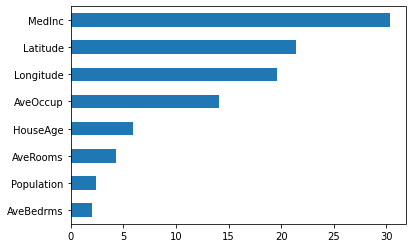

In [ ]:
sorted_feature_importance = model.feature_importances_.argsort() # отсортируем признаки по важности
# и построим график
(pd.Series(model.feature_importances_, index=housing.feature_names)
    .sort_values()
    .plot(kind='barh'))



Еще более интересные графики можно построить библиотекой [shap](https://shap.readthedocs.io/en/latest/). Установим ее. Она рассчитывает и показывает величины влияния признаков на результат. 

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 575.9/575.9 KB 8.8 MB/s eta 0:00:00


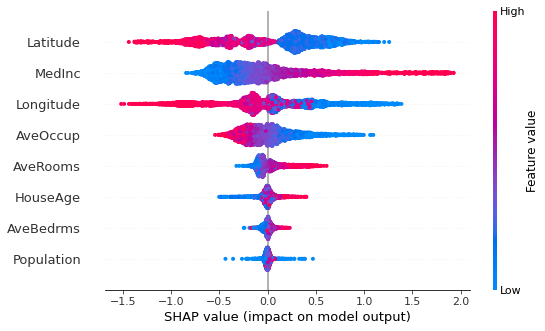

In [ ]:
import shap # подключим библиотеку
explainer = shap.TreeExplainer(model) # "объяснятор" для ансамблей деревьев 
shap_values = explainer.shap_values(X_test) # рассчитываем вклад признаков на тестовых данных
shap.summary_plot(shap_values, X_test, feature_names = housing.feature_names) # строим картинку

По горизонтальной оси показана степень влияния признака на результат, цветом - величина признака. 

В градиентном бустинге мы пытаемся скомпенсировать ошибки предыдущих моделей. Библиотека позволяет задать базовое решение (baseline), модель которую будем улучшать деревьями. Она задается выходами (и для обучения и для теста). 

In [ ]:
from sklearn.linear_model import Ridge # модель, которую будем использовать как базовую.
model_ridge=Ridge() # создаем
model_ridge.fit(X_train,y_train) # обучаем
model_ridge_train=model_ridge.predict(X_train) # считаем выходы для обучающих 
model_ridge_test=model_ridge.predict(X_test) # и тестовых данных

train_dataset = Pool(X_train, y_train, baseline=model_ridge_train) # пул для обучающих
test_dataset = Pool(X_test, y_test, baseline=model_ridge_test) #  пул для тестовых данных
model = CatBoostRegressor(loss_function='RMSE') # создаем ансамбль
model.fit(train_dataset,eval_set=test_dataset) # обучаем
pred=model.predict(test_dataset) # считаем выходы
r2_ridge = r2_score(y_test, model_ridge_test) # точночть базовой модели
r2 = r2_score(y_test, pred) # точночть ансамбля
print('Testing performance')
print('R2 Ridge: {:.2f}'.format(r2_ridge))
print('R2 Catboost: {:.2f}'.format(r2))

Learning rate set to 0.07828
0:	learn: 0.7115167	test: 0.7213193	best: 0.7213193 (0)	total: 11.8ms	remaining: 11.8s
1:	learn: 0.7019438	test: 0.7110709	best: 0.7110709 (1)	total: 17.7ms	remaining: 8.85s
2:	learn: 0.6932241	test: 0.7018858	best: 0.7018858 (2)	total: 24.3ms	remaining: 8.06s
3:	learn: 0.6851460	test: 0.6930552	best: 0.6930552 (3)	total: 31.8ms	remaining: 7.91s
4:	learn: 0.6775051	test: 0.6856935	best: 0.6856935 (4)	total: 36.7ms	remaining: 7.31s
5:	learn: 0.6701618	test: 0.6777533	best: 0.6777533 (5)	total: 41.8ms	remaining: 6.92s
6:	learn: 0.6638747	test: 0.6713760	best: 0.6713760 (6)	total: 47.1ms	remaining: 6.68s
7:	learn: 0.6580430	test: 0.6651202	best: 0.6651202 (7)	total: 52.6ms	remaining: 6.52s
8:	learn: 0.6528298	test: 0.6601031	best: 0.6601031 (8)	total: 57.6ms	remaining: 6.35s
9:	learn: 0.6478665	test: 0.6547171	best: 0.6547171 (9)	total: 62.8ms	remaining: 6.22s
10:	learn: 0.6430612	test: 0.6503921	best: 0.6503921 (10)	total: 67.7ms	remaining: 6.09s
11:	learn: 0

### Важное замечание

Никто не гарантирует, что добавление новых моделей в бустинге даст лучший результат, он может и ухудшиться.

Catboost по умолчанию возвращает лучшую из обученных моделей: если вы задали 100 моделей, а после добавления третьей началось ухудшение (на валидации), то в ансамбле останется три модели, остальные будут выброшены.


# Ссылки

Использованы и адаптированы материалы:

* https://scikit-learn.org/stable/modules/classes.html?highlight=ensemble#module-sklearn.ensemble 
* https://xgboost.readthedocs.io/en/latest/parameter.html
* https://catboost.ai/ 
* https://towardsdatascience.com/catboost-regression-in-6-minutes-3487f3e5b329 
* https://towardsdatascience.com/feature-importance-in-decision-trees-e9450120b445 